In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import torch.nn as nn
import glob
import pandas as pd


from pathlib import Path
from collections import defaultdict

import core.experiment
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity


from pytorch_utils.logging import LoggerReader
from pytorch_utils.evaluation import apply_model, argmax_and_accuracy
from nb_common import load_experiment_context, load_results, compute_latent, args_df_from_results

In [3]:
DEVICE = 'cuda:2'

In [4]:
def compute_cross_entropy_loss(path, run_i=0, train=True, device=DEVICE):
    exp_context = load_experiment_context(path, run_i=run_i)
    
    if train:
        ds = exp_context['ds_train']
    else:
        ds = exp_context['ds_test']
        
    Y_hat, Y = apply_model(dataset=ds, model=exp_context['model'], device=device, shuffle=False)
    
    return torch.nn.functional.cross_entropy(
        torch.tensor(Y_hat), 
        torch.tensor(Y)
        , reduction='mean').item()

In [5]:
def compute_latent_innerproducts_norm(path, run_i=0, train=True, sub_sample=None, device=DEVICE):
    Z, Y = compute_latent(path, run_i, train, device=device)
    
    if sub_sample is not None:
        assert isinstance(sub_sample, int)
        I = torch.randperm(len(Z))
        I = I[:sub_sample]
        Z = [Z[i] for i in I]
        Y = [Y[i] for i in I]
    
    labels = set(Y)
    assert labels == set(range(len(labels)))
    
    bs = 512
    
    ds_1 = torch.utils.data.dataset.TensorDataset(torch.tensor(Z), torch.tensor(Y))    
    dl_1 = torch.utils.data.DataLoader(ds_1, shuffle=False, batch_size=bs)
    
    list_D = []
    list_Y = []
    list_N = []
    
    for batch_i, (x_1, y_1) in enumerate(dl_1):
        
        Z_, Y_ = ds_1.tensors
        Z_, Y_ = Z_[bs*batch_i:], Y_[bs*batch_i:]
        ds_2 = torch.utils.data.dataset.TensorDataset(Z_, Y_)
        dl_2 = torch.utils.data.DataLoader(ds_2, shuffle=False, batch_size=bs)
        
        for batch_j, (x_2, y_2) in enumerate(dl_2):    
                        
            D = (x_1.unsqueeze(0)*x_2.unsqueeze(1)).sum(dim=-1)
            
            x_1_norm = torch.norm(x_1, p=2, dim=1)
            x_2_norm = torch.norm(x_2, p=2, dim=1)
            
            N = torch.cat([
                x_2_norm.view(-1, 1, 1).expand(-1, x_1_norm.size(0), -1),
                x_1_norm.view(1, -1, 1).expand(x_2_norm.size(0),-1, -1)
            ], dim=2)
            
            Y = torch.cat([
                y_2.view(-1, 1, 1).expand(-1, x_1.size(0), -1),
                y_1.view(1, -1, 1).expand(x_2.size(0),-1, -1)
            ], dim=2) 
            
            # Test that this is really implemented the right way
            #             y_1 = torch.tensor([0, 1, 2])
            #             y_2 = torch.tensor([3, 4, 5, 6])
            #             x_1 = torch.randn(3, 10)
            #             x_2 = torch.randn(4, 10)

            #             D = (x_1.unsqueeze(0)*x_2.unsqueeze(1)).sum(dim=-1)

            #             Y = torch.cat([
            #                 y_2.view(-1, 1, 1).expand(-1, x_1.size(0), -1),
            #                 y_1.view(1, -1, 1).expand(x_2.size(0),-1, -1)
            #             ], dim=2)

            #             for i, j in Y.view(-1, 2):
            #                 i = i -3

            #                 assert D[i, j].item() == (x_2[i]*x_1[j]).sum().item()
            
            # Sort labels ascendingly 
            Y, I = Y.sort(dim=-1)
            
            # Apply sorting permutation to norms 
            N = N.gather(2, I)
            
            # The first batch in the batch_j loop is always the batch_i-th batch. 
            # We take the upperdiagonal part of this innerproduct matrix. 
            if batch_j == 0:
                mask = torch.ones_like(D, dtype=torch.bool).triu(diagonal=1)
                
                D = D[mask]
                Y = Y[mask]      
                N = N[mask]
            
            
            list_D.append(D.view(-1))
            list_Y.append(Y.view(-1, 2))
            list_N.append(N.view(-1, 2))
            
                
    D, Y, N = torch.cat(list_D, dim=0), torch.cat(list_Y, dim=0), torch.cat(list_N, dim=0)
    
    assert D.size(0) == len(Z)*(len(Z)-1) / 2
    assert D.size(0) == Y.size(0)
    assert Y.size() == N.size()

    return D, Y, N


def compute_latent_norms(path, run_i=0, train=True, device=DEVICE):
    Z, Y = compute_latent(path, run_i, train, device=device)
    
    return torch.tensor(Z).norm(p=2, dim=-1), Y


def compute_linear_weights_norm(path, run_i=0):
    exp_context = load_experiment_context(path, run_i=run_i)
    return exp_context['model'].cls.weight.norm(p=2, dim=-1).detach()


def compute_latent_innerprod_with_weight(path, run_i=0, train=True, device=DEVICE):
    exp_context = load_experiment_context(path, run_i=run_i)
   
    if exp_context['args']['model'][1]['linear_cfg'][1]['bias']:
        print('warning')
    
    if train:
        ds = exp_context['ds_train']
    else:
        ds = exp_context['ds_test']
        
    Y_hat, Y = apply_model(dataset=ds, model=exp_context['model'], device=device)
    
    return torch.tensor(Y_hat), Y
    
    

In [6]:
# exp_context = load_experiment_context(named_results['CEF'].path, run_i=0)
# W = exp_context['model'].cls.weight.detach()

In [23]:
root = Path('/home/pma/chofer/repositories/py_supcon_vs_ce/results_xmas_performance/')
named_results = {
#     'CEV':   9, 
#     'SUP':   2, 
#     'CEF':  49 
    'CEV':   13, 
    'SUP':   5, 
    'CEF':  48 #->  

    
#     'CEV':   8, 
#     'SUP':   0, 
#     'CEF':  48
    # CIFAR100
    #'SUP': 4,
    #'CEF': 56,
    #'CEV': 12
    
}

args_simple = {
    'model_comp': lambda a: a['model'][1]['compactification_cfg'][0], 
    'model_lin': lambda a: a['model'][1]['linear_cfg'][0], 
    'loss': lambda a: a['losses'][0][0],
    'scheduler': lambda a: a['scheduler'],
    'ds_train': lambda a: a['ds_train'],
    'augment': lambda a: a['augment']
}

latent_geometry = {}
results = load_results(root)
named_results = {k: results[v] for k, v in named_results.items()}
args_df_from_results(named_results.values(), args_simple=args_simple)

,model_comp,model_lin,loss,scheduler,ds_train,augment,progress
0,none,Linear,CrossEntropy,exponential,cifar100_train,standard,True
1,sphere_l2,Linear,SupConLoss,exponential,cifar100_train,standard,True
2,none,FixedSphericalSimplexLinear,CrossEntropy,exponential,cifar10_train,none,True


In [20]:
def compute_angular_distance(data):
    #return cosine_similarity(data)

    return 1-np.arccos(np.clip(cosine_similarity(data),-1.0,1.0))/np.pi    

def compute_wei_cross_angular_distances(result):
    exp_context = load_experiment_context(result.path, run_i=0)

    # extract classifier weight
    W = exp_context['model'].cls.weight.detach().numpy()

    # compute angular distance and get cross-class parts
    nrows, ncols = W.shape
    CW = compute_angular_distance(W)
    CW_lower_triu = CW[np.triu_indices(nrows, k=1)]
    return CW_lower_triu

def compute_cls_cross_angular_distances(result, latent_dim=512):
    
    # get latent codes
    Z, Y = compute_latent(result.path, 0, True, device='cuda:2')
    ZM = torch.tensor(Z)
    YM = torch.tensor(Y)
    
    nlabels = len(np.unique(YM))

    # compute class means
    means = np.zeros((nlabels, latent_dim))
    for i in range(nlabels):
        means[i,:] = ZM[YM==i].mean(dim=0).numpy()

    # compute angular distance across means and extract cross-class parts
    nrows, ncols = means.shape
    D = compute_angular_distance(means)
    D_lt = D[np.triu_indices(nrows,k=1)]
    return D_lt 

def compute_class_mean_ips(result, latent_dim=512):
    Z, Y = compute_latent(result.path, 0, True, device='cuda:2')
    ZM = torch.tensor(Z)
    YM = torch.tensor(Y)
    
    nlabels = len(np.unique(YM))

    ips = []
    for i in range(nlabels):
        a = ZM[YM==i].numpy()
        b = ZM[YM==i].mean(dim=0).numpy().reshape(1,latent_dim)
        ip = 1-np.arccos(np.clip(cosine_similarity(a,b),-1.0,1.0))/np.pi 
        ips.append(ip.reshape(-1))
    
    ips_np = np.concatenate(ips)
    return ips_np

def compute_class_collapse(result, latent_dim=512):
    Z, Y = compute_latent(result.path, 0, True, device='cuda:2')
    ZM = torch.tensor(Z)
    YM = torch.tensor(Y)
    
    nlabels = len(np.unique(YM))

    collapse = []
    for i in range(nlabels):
        collapse.append((ZM[YM==i] - ZM[YM==i].mean(axis=0)).norm(dim=1,p=2).numpy())
    return collapse

In [21]:
P_cev_CAD = compute_cls_cross_angular_distances(named_results['CEV'])
P_sup_CAD = compute_cls_cross_angular_distances(named_results['SUP'])
P_cef_CAD = compute_cls_cross_angular_distances(named_results['CEF'])

P_sup_CMIPS = compute_class_mean_ips(named_results['SUP'], latent_dim=512)
P_cev_CMIPS = compute_class_mean_ips(named_results['CEV'], latent_dim=512)
P_cef_CMIPS = compute_class_mean_ips(named_results['CEF'], latent_dim=512)

W_cef_CAD = compute_wei_cross_angular_distances(named_results['CEF'])
W_cev_CAD = compute_wei_cross_angular_distances(named_results['CEV'])

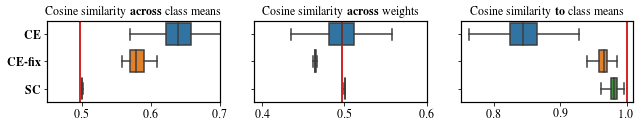

In [22]:
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 1.2

def geom_properties(cad, cc, weights, outfile=None, K=10):
    plt.rc('text', usetex=True)
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Times"],
    })
    
    fig, (ax1, ax3, ax2) = plt.subplots(1,3,figsize=(10.5,1.5))
    
    sns.boxplot(data=weights, orient='h', ax=ax3,showfliers=False)
    ax3.set_yticklabels([r'\textbf{CE}',r'\textbf{CE} (Fix)',r'\textbf{SC}'], fontsize=12)
    ax3.axvline(x=1-np.arccos(-1.0/(K-1))/np.pi, ymin=0, ymax=2, color='tab:red',linewidth=2)
    ax3.set_title(r'Cosine similarity \textbf{across} weights')
    ax3.set_yticklabels([])
    ax3.tick_params(axis='both', which='major', labelsize=12)
    ax3.tick_params(axis='both', which='minor', labelsize=12)
    ax3.set_xlim(0.39,0.6)

    
    sns.boxplot(data=cad, orient='h', ax=ax1,showfliers=False)
    ax1.set_yticklabels([r'\textbf{CE}',r'\textbf{CE-fix}',r'\textbf{SC}'], fontsize=12)
    ax1.axvline(x=1-np.arccos(-1.0/(K-1))/np.pi, ymin=0, ymax=2, color='tab:red',linewidth=2)
    ax1.set_title(r'Cosine similarity \textbf{across} class means')
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='minor', labelsize=12)
    ax1.set_xlim(0.45,0.7)
    
    sns.boxplot(data=cc, orient='h', ax=ax2,showfliers=False)
    ax2.axvline(x=1.0, ymin=0, ymax=2, color='tab:red',linewidth=2)
    #ax2.text(1.0035, 1.3, 'Optimal', rotation=90, color='tab:red', fontsize=12)
    ax2.set_xlim(0.75,1.01)
    ax2.set_yticklabels([])
    ax2.set_title(r'Cosine similarity \textbf{to} class means', fontsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='both', which='minor', labelsize=12)

    if outfile is not None:
        plt.savefig(outfile, bbox_inches='tight', pad_inches=0.05)


geom_properties(cad=[P_cev_CAD, P_cef_CAD, P_sup_CAD], 
                cc=[P_cev_CMIPS, P_cef_CMIPS, P_sup_CMIPS], 
                weights=[W_cev_CAD, W_cef_CAD, P_sup_CAD], outfile='/tmp/real_data_simplex_eval/geometry_cifar100.pdf',
                K=100)


In [128]:
# import matplotlib
# matplotlib.rcParams['axes.linewidth'] = 1.2

# def boxplot_ce(points, weights):
#     plt.rc('text', usetex=True)
#     plt.rcParams.update({
#         "text.usetex": True,
#         "font.family": "serif",
#         "font.serif": ["Times"],
#     })
    
#     assert len(points) == len(weights)
    
#     df = pd.DataFrame({
#         'data': np.concatenate((points, weights)),
#         'key' : np.concatenate((['means']*len(points), ['weights']*len(weights)))})

#     plt.figure(figsize=(1.5,2))
#     sns.violinplot(x='key', y='data', data=df) #color="0.15")
#     plt.xlabel('')
#     plt.ylabel('')
#     plt.ylim(-0.2, 0.3)    
    
# def boxplot_sc(points, title=None, outfile=None):    
#     plt.rc('text', usetex=True)
#     plt.rcParams.update({
#         "text.usetex": True,
#         "font.family": "serif",
#         "font.serif": ["Times"],
#     })
    
#     df = pd.DataFrame({
#         'data': points,
#         'key' : np.array(['means']*len(points)).reshape(-1)})

#     fig, ax = plt.subplots(figsize=(1,2))
#     ax.axes.xaxis.set_visible(False)
#     ax.tick_params(axis='both', which='major', labelsize=12)
#     ax.tick_params(axis='both', which='minor', labelsize=12)
    
#     sns.violinplot(x='key', y='data', data=df)
#     plt.ylim(0.45, 0.75)
#     plt.xlabel('')
#     plt.ylabel('')
#     #plt.axhline(y=-1/9.0, xmin=0, xmax=1, color='tab:green')
    
#     if title is not None: plt.title(title, fontsize=12)
#     if outfile is not None:
#         plt.savefig(outfile, bbox_inches='tight', pad_inches=0.05)
    

# def boxplot_class_collapse(data, title=None, zoom=False, outfile=None):
#     plt.rc('text', usetex=True)
#     plt.rcParams.update({
#         "text.usetex": True,
#         "font.family": "serif",
#         "font.serif": ["Times"],
#     })
    
#     fig, ax = plt.subplots(figsize=(1.5,2))
#     ax.tick_params(axis='both', which='major', labelsize=12)
#     ax.tick_params(axis='both', which='minor', labelsize=12)
#     sns.violinplot(np.array(data).reshape(-1),orient='v',color='tab:red')
#     plt.ylabel('',fontsize=12)
#     if title is not None:
#         plt.title(title, fontsize=12)
#     plt.ylim(0,4)
    
#     if zoom:
#         axins = ax.inset_axes([0.4, 0.1, 0.4, 1.0])
#         sns.violinplot(np.array(data).reshape(-1),orient='v',color='tab:red', ax=axins)
#         axins.set_xlim(-0.5, 0.5)
#         axins.set_ylim(0, 0.1)
#         ax.indicate_inset_zoom(axins)

#     if outfile is not None:
#         plt.savefig(outfile, bbox_inches='tight', pad_inches=0.05)
        
# boxplot_sc(P_sup_CAD, title=r'\bf{SC}',         outfile='/tmp/exp_fig/SUP_cad.pdf')
# boxplot_sc(P_cev_CAD, title=r'\bf{CE-Vanilla}', outfile='/tmp/exp_fig/CEV_cad.pdf')
# boxplot_sc(P_cef_CAD, title=r'\bf{CE (Fix W)}',  outfile='/tmp/exp_fig/CEF_cad.pdf')

# boxplot_class_collapse(P_sup_CC, r'\bf{SC}', zoom=True,  outfile='/tmp/exp_fig/SC_collapse.pdf')
# boxplot_class_collapse(P_cev_CC, r'\bf{CEV}', zoom=False, outfile='/tmp/exp_fig/CEV_collapse.pdf')
# boxplot_class_collapse(P_cef_CC, r'\bf{CEF}', zoom=False, outfile='/tmp/exp_fig/CEF_collapse.pdf')

In [ ]:
weight_norms = {}
for k, r in named_results.items():
    print(k)
    weight_norms[k] = compute_linear_weights_norm(r.path)

In [ ]:
latent_norms = {}
for k, r in named_results.items(): 
    print(k)
    latent_norms[k] = compute_latent_norms(r.path, train=True)

In [ ]:
latent_innerprod_with_weight = {}
for k, r in named_results.items(): 
    print(k)
    latent_innerprod_with_weight[k] = compute_latent_innerprod_with_weight(r.path, train=True)

In [ ]:
latent_geometry = dict()
for k, r in named_results.items(): 
    print(k)
    latent_geometry[k] = compute_latent_innerproducts_norm(r.path, train=True, sub_sample=10000, device='cpu')

In [ ]:
for k in named_results:
    fig, axes = plt.subplots(1, 4, figsize=(4*5, 5))
    fig.suptitle(k)
    
    ln, Y = latent_norms[k]
    Y = torch.tensor(Y)
    labels = sorted(set(Y.tolist()))
    
    axes[0].violinplot([ln[Y == y].numpy() for y in labels])
    axes[0].set_title('norm distributions')
    
    wn = weight_norms[k]
    axes[0].plot(list(range(1, len(labels)+1)), wn.numpy(), '.', label='norms of weights')
    
    prod, YY, norm = latent_geometry[k]
    tmp = {}
    for y_1 in range(len(labels)):
        for y_2 in range(y_1, len(labels)):
            tmp[y_1, y_2] = prod[(YY[:, 0] == y_1) & (YY[:, 1] == y_2)]
            
    mat_mean = torch.zeros((len(labels), len(labels)))
    mat_std = torch.zeros((len(labels), len(labels)))
    
    axes[1].set_title('inner products mean')
    for (y_1, y_2), prods in tmp.items():
        mean = prods.mean().item()
        mat_mean[y_1, y_2] = mean
        mat_mean[y_2, y_1] = mean
        
    sns.heatmap(mat_mean, ax=axes[1])
    
    axes[2].set_title('innner products std')
    for (y_1, y_2), prods in tmp.items():
        std = prods.std().item()
        mat_mean[y_1, y_2] = std
        mat_mean[y_2, y_1] = std
        
    sns.heatmap(mat_mean, ax=axes[2])
    
    if not 'supcon' in k:
    
        axes[3].set_title('inner products to correct weight')
        inprods, Y = latent_innerprod_with_weight[k]

        Y = torch.tensor(Y).long()
        I = torch.zeros_like(inprods, dtype=torch.bool)
        I.scatter_(1, Y.unsqueeze(1), 1)

        inprods_true = inprods[I]
        inprods_true = [inprods_true[Y == y] for y in range(len(labels))]
        axes[3].violinplot(inprods_true)

        inprods_false = inprods[~I].view(-1, len(labels) - 1)
        inprods_false = [inprods_false[Y == y].view(-1) for y in range(len(labels))]
        axes[3].violinplot(inprods_false)
    
    
    